# COMEÇO DETECTRON2

In [1]:
# install dependencies: 
!python -m pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /opt/conda/lib/python3.10/site-packages/setuptools/config/setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
      !!
      
              ********************************************************************************
              The license_file parameter is deprecated, use license_files instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        parsed = self.parsers.get(

In [2]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15713, done.
remote: Counting objects: 100% (436/436), done.
remote: Compressing objects: 100% (326/326), done.
remote: Total 15713 (delta 196), reused 296 (delta 104), pack-reused 15277
Receiving objects: 100% (15713/15713), 6.51 MiB | 22.37 MiB/s, done.
Resolving deltas: 100% (11312/11312), done.
  Obtaining dependency information for pycocotools>=2.0.2 from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for yacs>=0.1.8 from https://files.pythonhosted.org/packages/38/4f/fe9a4d472aa867878ce3bb7efb16654c5d63672b86dc0e6e953a67018433/yacs-0.1.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for iopath<0.1.10,>=0.1.7 from

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [5]:
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [6]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105942,00028518_011.png,No Finding,11,28518,48,F,AP,3056,2544,0.139,0.139,NaN,/kaggle/input/data/images_012/images/00028518_...
60345,00014898_000.png,No Finding,0,14898,46,M,PA,2936,2948,0.143,0.143,NaN,/kaggle/input/data/images_007/images/00014898_...
67283,00016607_044.png,Infiltration,44,16607,63,M,PA,2992,2991,0.143,0.143,NaN,/kaggle/input/data/images_008/images/00016607_...


# Antes de tudo precisamos reescrever a BBOX no formato json

In [7]:
bbox_csv = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Mass': 4,
 'Nodule': 5,
 'Pneumonia': 6,
 'Pneumothorax': 7}

In [8]:
bbox_csv_copy = bbox_csv.copy(deep=True)

In [9]:
bbox_csv = bbox_csv[~bbox_csv['Finding Label'].isin(['Nodule', 'Mass', 'Pneumothorax'])]
bbox_csv['Finding Label'].value_counts()

Finding Label
Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Name: count, dtype: int64

In [10]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Pneumonia': 4}

In [11]:
list_exc = []
cats_exc = {k: bbox_csv['Finding Label'].value_counts()[k] - bbox_csv['Finding Label'].value_counts().min() for k in categorys}

for cat in categorys:
    count = 0
    df_catx = bbox_csv[bbox_csv['Finding Label'] == cat]
    for i, r in df_catx.iterrows():
        if len(bbox_csv[bbox_csv['Image Index'] == r['Image Index']]['Image Index'].to_list()) == 1 and count < cats_exc[cat]:
            list_exc.append(r['Image Index'])
            count += 1

df_new = bbox_csv[~bbox_csv['Image Index'].isin(list_exc)]
df_new

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966,NaN,NaN,NaN
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763,NaN,NaN,NaN
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458,NaN,NaN,NaN
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458,NaN,NaN,NaN
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [12]:
bbox_csv = df_new.copy()
#bbox_csv = bbox_csv_copy.copy(deep=True)
bbox_csv[bbox_csv['Image Index'] == '00008814_010.png']

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
308,00008814_010.png,Effusion,195.128889,412.197934,665.600000,105.813333,NaN,NaN,NaN
461,00008814_010.png,Infiltrate,205.368889,392.855712,643.982222,86.471111,NaN,NaN,NaN
965,00008814_010.png,Atelectasis,195.527118,407.646823,669.013333,64.853333,NaN,NaN,NaN


In [13]:
bbox_csv.to_csv('imagens.csv')

In [14]:
dataentry = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
dataentry

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [15]:
train_val_list_txt = pd.read_csv('/kaggle/input/data/train_val_list.txt', sep=' ', header=None)
train_val_list_txt

,0
0,00000001_000.png
1,00000001_001.png
2,00000001_002.png
3,00000002_000.png
4,00000004_000.png
...,...
86519,00030789_000.png
86520,00030793_000.png
86521,00030795_000.png
86522,00030801_000.png


In [16]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Effusion': 2,
 'Infiltrate': 3,
 'Pneumonia': 4}

In [17]:
bbox_csv['image_id'] = bbox_csv.apply(lambda x: x['Image Index'].split('.')[0], axis = 1)
bbox_csv['category_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis = 1)
bbox_csv['height'] = None
bbox_csv['width'] = None

for i in bbox_csv['Image Index']:
    if i in dataentry['Image Index'].values:
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['height']] = dataentry.loc[dataentry['Image Index'] == i, ['Height]']].values[0][0]
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['width']] = dataentry.loc[dataentry['Image Index'] == i, ['OriginalImage[Width']].values[0][0]

bbox_csv

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8,image_id,category_id,height,width
60,00007676_002.png,Atelectasis,360.677966,439.629386,82.440678,136.677966,NaN,NaN,NaN,00007676_002,0,2048,2500
61,00005089_002.png,Atelectasis,648.135593,574.137861,263.593220,188.745763,NaN,NaN,NaN,00005089_002,0,2048,2500
62,00020857_008.png,Atelectasis,190.372881,571.968369,562.983051,202.847458,NaN,NaN,NaN,00020857_008,0,2544,3056
63,00012291_008.png,Atelectasis,232.677966,631.629386,226.711864,74.847458,NaN,NaN,NaN,00012291_008,0,2991,2990
64,00018762_002.png,Atelectasis,603.661017,616.786447,257.084746,81.355932,NaN,NaN,NaN,00018762_002,0,2991,2506
...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN,00029464_015,0,2021,2021
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN,00025769_001,0,2544,3056
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN,00016837_002,0,2446,2592
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN,00020124_003,0,2991,2754


In [18]:
def to_annotation(rowbbox):
    if rowbbox['category_id'] == 8: # PARA OS CASOS QUE NÃO POSSUEM DETECÇÕES
        dict_return = {
            'file_name': str(rowbbox['Image Index']),
            'image_id': str(rowbbox['image_id']),
            'height': rowbbox['height'],
            'width': rowbbox['width'],
            'annotations': []
        }
        return dict_return
    
    dict_return = {
        'file_name': str(rowbbox['Image Index']),
        'image_id': str(rowbbox['image_id']),
        'height': rowbbox['height'],
        'width': rowbbox['width'],
        'annotations': [
            {
                'bbox': [rowbbox['Bbox [x'], rowbbox['y'], rowbbox['w'], rowbbox['h]']],
                'bbox_mode': 1,
                'category_id': rowbbox['category_id']
            }
        ]
    }
    return dict_return

In [19]:
list_json = []
for index, row in bbox_csv.iterrows():
    presente = False
    indice = 0
    for i in range(len(list_json)):
        if str(row['Image Index']) == list_json[i]['file_name']:
            presente = True
            indice = i
            break
    
    if presente:
        list_json[i]['annotations'].append(
            {
                'bbox': [row['Bbox [x'], row['y'], row['w'], row['h]']],
                'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': row['category_id']
            }
        )
    else:
        list_json.append(to_annotation(row))

len(list_json)

529

In [20]:
df_ttt = pd.DataFrame(list_json)
df_ttt.to_json('temp.json', orient='records')

In [21]:
for i in range(len(list_json)):
    for key, value in all_image_paths.items():
        if list_json[i]['file_name'] in key:
            list_json[i]['file_name'] = value
list_json[0]

{'file_name': '/kaggle/input/data/images_004/images/00007676_002.png',
 'image_id': '00007676_002',
 'height': 2048,
 'width': 2500,
 'annotations': [{'bbox': [360.677966101695,
    439.629386255297,
    82.4406779661017,
    136.677966101695],
   'bbox_mode': 1,
   'category_id': 0}]}

In [22]:
# To ensure bbox always remap to original image size
for i in range(len(list_json)):
    image = cv2.imread(list_json[i]['file_name'])
    list_json[i]["width"] = image.shape[1]
    list_json[i]["height"] = image.shape[0]

l = None
for i in list_json:
    if i['image_id'] == '00008814_010':
        l = i
l

{'file_name': '/kaggle/input/data/images_004/images/00008814_010.png',
 'image_id': '00008814_010',
 'height': 1024,
 'width': 1024,
 'annotations': [{'bbox': [195.128888888889,
    412.197934027778,
    665.6,
    105.813333333333],
   'bbox_mode': 1,
   'category_id': 2},
  {'bbox': [205.368888888889,
    392.855711805556,
    643.982222222222,
    86.4711111111111],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 3},
  {'bbox': [195.527118055556,
    407.646822916667,
    669.013333333333,
    64.8533333333333],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0}]}

In [23]:
listststs = {}
train_data = {}
val_data = {}
test_data = {}

for i in category_ids.values():
    listststs[i] = []
    for j in list_json:
        try:
            if j['annotations'][0]['category_id'] == i:
                listststs[i].append(j)
        except:
            if i == 8:
                listststs[i].append(j)

for i, x in listststs.items():
    train_data[i] = x[:int((len(x)+1)*.80)] #80% to training set
    val_data[i] = x[int((len(x)+1)*.80):int((len(x)+1)*.90)] #10% to val set
    test_data[i] = x[int((len(x)+1)*.90):] #10% to val set

yyy = []
xxx = []
zzz = []

for i, x in train_data.items():
    for y in x:
        yyy.append(y)

for i, x in val_data.items():
    for y in x:
        xxx.append(y)
        
for i, x in test_data.items():
    for y in x:
        zzz.append(y)

In [24]:
len(xxx), len(yyy), len(zzz)

(53, 424, 52)

In [25]:
import json
with open('/kaggle/working/treino.json', 'w', encoding='utf-8') as f:
    json.dump(yyy, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/val.json', 'w', encoding='utf-8') as f:
    json.dump(xxx, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/test.json', 'w', encoding='utf-8') as f:
    json.dump(zzz, f, ensure_ascii=False, indent=4)

In [26]:
xray_metadata = {}

def registrar(d):
    if d == 'train':
        return yyy
    if d == 'val':
        return xxx
    return zzz

for d in ["train", "val", "test"]:
    DatasetCatalog.register("xray_" + d, lambda d=d: registrar(d))
    MetadataCatalog.get("xray_" + d).set(thing_classes=list(categorys))
xray_metadata['train'] = MetadataCatalog.get("xray_train")
xray_metadata['val'] = MetadataCatalog.get("xray_val")
xray_metadata['test'] = MetadataCatalog.get("xray_test")

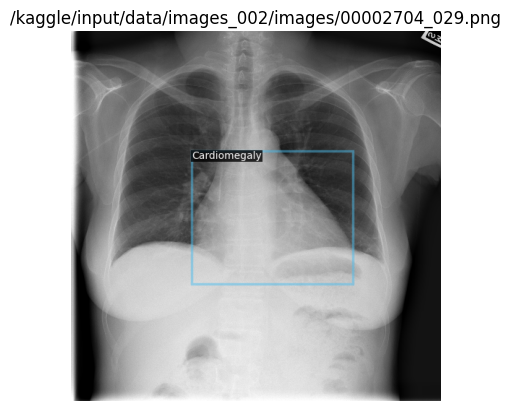

In [27]:
for d in random.sample(yyy, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=xray_metadata['train'], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
    plt.title(d['file_name'])
    plt.axis('off')

# RetinaNET

In [28]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [29]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("xray_train",)
cfg.DATASETS.VAL = ("xray_val",)
cfg.DATASETS.TEST = ("xray_val",)
cfg.TEST.EVAL_PERIOD = 50
#cfg.DATALOADER.NUM_WORKERS = 2
#cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # PARA INCLUIR OS EXEMPLOS NEGATIVOS
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
#cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categorys)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [30]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/30 22:13:44 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_971ab9.pkl: 228MB [00:09, 23.5MB/s]                              


[05/30 22:13:54 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/30 22:14:19 d2.utils.events]:  eta: 0:17:38  iter: 19  total_loss: 2.093  loss_cls: 1.304  loss_box_reg: 0.7944    time: 1.1510  last_time: 1.1465  data_time: 0.0555  last_data_time: 0.0730   lr: 0.00019981  max_mem: 10364M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[05/30 22:14:51 d2.utils.events]:  eta: 0:17:17  iter: 39  total_loss: 1.328  loss_cls: 0.767  loss_box_reg: 0.5704    time: 1.0969  last_time: 1.0971  data_time: 0.0394  last_data_time: 0.0245   lr: 0.00039961  max_mem: 10364M
[05/30 22:15:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/30 22:15:02 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/30 22:15:02 d2.data.common]: Serializing 53 elements to byte tensors and concatenating them all ...
[05/30 22:15:02 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/30 22:15:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/30 22:15:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/30 22:15:02 d2.ev

In [31]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("xray_val", tasks=("bbox",), distributed=False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "xray_val")
evaluation_results = inference_on_dataset(trainer.model, test_loader, evaluator)

[05/30 22:34:51 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/30 22:34:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/30 22:34:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/30 22:34:51 d2.data.common]: Serializing 53 elements to byte tensors and concatenating them all ...
[05/30 22:34:51 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/30 22:34:51 d2.evaluation.evaluator]: Start inference on 53 batches
[05/30 22:34:53 d2.evaluation.evaluator]: Inference done 23/53. Dataloading: 0.0014 s/iter. Inference: 0.0644 s/iter. Eval: 0.0004 s/iter. Total: 0.0662 s/iter. ETA=0:00:01
[05/30 22:34:55 d2.evaluation.evaluator]: Total inference time: 0:00:03.251270 (0.067735 s / iter per device, on 1 devices)
[05/30 22:34:55 d2.evaluation.evaluator]: Total in

In [32]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
experiment_metrics[0]

{'data_time': 0.032306041999959234,
 'eta_seconds': 1058.6775193400058,
 'iteration': 19,
 'loss_box_reg': 0.7944042086601257,
 'loss_cls': 1.3040509223937988,
 'lr': 0.00019981,
 'num_pos_anchors': 32.8125,
 'rank_data_time': 0.032306041999959234,
 'time': 1.080283183000006,
 'timetest': 12.0,
 'total_loss': 2.0932226479053497}

In [33]:
!mkdir /kaggle/working/imagens

In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/30 22:34:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [35]:
import cv2

predictions = {'image_id': [], 'class': [], 'bbox': [], 'score': []}

for i in zzz:
    f = i['file_name']
    img = cv2.imread(f)
    outputs = predictor(img)
    
    for j in range(len(outputs["instances"].pred_boxes.tensor.cpu().numpy())):
        predictions['image_id'].append(i['file_name'])
        predictions['bbox'].append(outputs["instances"].pred_boxes.tensor.cpu().numpy()[j])
        predictions['class'].append(outputs["instances"].pred_classes.cpu().numpy()[j])
        predictions['score'].append(outputs["instances"].scores.cpu().numpy()[j])

In [36]:
res_df = pd.DataFrame(predictions)
res_df.to_csv('/kaggle/working/previsoes.csv', index=False)
res_df

,image_id,class,bbox,score
0,/kaggle/input/data/images_001/images/00000583_...,4,"[698.21576, 396.60086, 893.60266, 730.58325]",0.330655
1,/kaggle/input/data/images_001/images/00000583_...,3,"[307.27182, 441.8503, 490.30792, 592.28125]",0.274155
2,/kaggle/input/data/images_001/images/00000583_...,2,"[704.492, 380.0073, 904.45013, 693.5894]",0.269516
3,/kaggle/input/data/images_001/images/00000583_...,2,"[679.0496, 339.73157, 964.3324, 880.5728]",0.224543
4,/kaggle/input/data/images_001/images/00000583_...,4,"[258.65695, 451.3853, 528.51013, 818.553]",0.223086
...,...,...,...,...
3852,/kaggle/input/data/images_012/images/00029469_...,3,"[526.58246, 576.97473, 730.34485, 975.18207]",0.051372
3853,/kaggle/input/data/images_012/images/00029469_...,0,"[209.51956, 555.499, 514.2858, 918.8733]",0.050870
3854,/kaggle/input/data/images_012/images/00029469_...,0,"[568.2793, 917.2624, 677.29376, 983.86615]",0.050861
3855,/kaggle/input/data/images_012/images/00029469_...,4,"[125.23434, 685.1721, 262.46155, 889.86285]",0.050663


In [ ]:
!zip -r /kaggle/working/retinanet_35000.zip /kaggle/working/output

# Detectron2 Faster R-CNN

In [28]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

In [29]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("xray_train",)
cfg.DATASETS.VAL = ("xray_val",)
cfg.DATASETS.TEST = ("xray_val",)
cfg.TEST.EVAL_PERIOD = 50
#cfg.DATALOADER.NUM_WORKERS = 2
#cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # PARA INCLUIR OS EXEMPLOS NEGATIVOS
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8  # This is the real "batch size" commonly known to deep learning people
#cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categorys)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [30]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/30 13:01:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 70.8MB/s]                            


[05/30 13:01:47 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/30 13:02:06 d2.utils.events]:  eta: 0:13:41  iter: 19  total_loss: 1.007  loss_cls: 0.8557  loss_box_reg: 0.07008  loss_rpn_cls: 0.07377  loss_rpn_loc: 0.01201    time: 0.8395  last_time: 0.8849  data_time: 0.0510  last_data_time: 0.0672   lr: 0.00039962  max_mem: 5721M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[05/30 13:02:34 d2.utils.events]:  eta: 0:13:23  iter: 39  total_loss: 0.3153  loss_cls: 0.1671  loss_box_reg: 0.088  loss_rpn_cls: 0.04223  loss_rpn_loc: 0.009274    time: 0.8315  last_time: 0.7496  data_time: 0.0373  last_data_time: 0.0306   lr: 0.00079922  max_mem: 5721M
[05/30 13:02:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/30 13:02:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/30 13:02:42 d2.data.common]: Serializing 53 elements to byte tensors and concatenating them all ...
[05/30 13:02:42 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/30 13:02:42 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [05/30 13:02:42 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in ex

In [31]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("xray_val", tasks=("bbox",), distributed=False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "xray_val")
evaluation_results = inference_on_dataset(trainer.model, test_loader, evaluator)

[05/30 13:18:10 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/30 13:18:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/30 13:18:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/30 13:18:10 d2.data.common]: Serializing 53 elements to byte tensors and concatenating them all ...
[05/30 13:18:10 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/30 13:18:10 d2.evaluation.evaluator]: Start inference on 53 batches
[05/30 13:18:12 d2.evaluation.evaluator]: Inference done 43/53. Dataloading: 0.0015 s/iter. Inference: 0.0502 s/iter. Eval: 0.0004 s/iter. Total: 0.0521 s/iter. ETA=0:00:00
[05/30 13:18:13 d2.evaluation.evaluator]: Total inference time: 0:00:02.525569 (0.052616 s / iter per device, on 1 devices)
[05/30 13:18:13 d2.evaluation.evaluator]: Total in

In [32]:
import json
import matplotlib.pyplot as plt

experiment_folder = './output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
experiment_metrics[0]

{'data_time': 0.032772231999985024,
 'eta_seconds': 821.8608025599701,
 'fast_rcnn/cls_accuracy': 0.9752197265625,
 'fast_rcnn/false_negative': 1.0,
 'fast_rcnn/fg_cls_accuracy': 0.0,
 'iteration': 19,
 'loss_box_reg': 0.07008441537618637,
 'loss_cls': 0.8557019233703613,
 'loss_rpn_cls': 0.07377208024263382,
 'loss_rpn_loc': 0.012013777624815702,
 'lr': 0.00039962,
 'rank_data_time': 0.032772231999985024,
 'roi_head/num_bg_samples': 502.25,
 'roi_head/num_fg_samples': 9.75,
 'rpn/num_neg_anchors': 251.625,
 'rpn/num_pos_anchors': 4.375,
 'time': 0.8386334719999695,
 'timetest': 12.0,
 'total_loss': 1.0074606924317777}

In [33]:
!mkdir /kaggle/working/imagens

In [34]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/30 13:18:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [35]:
import cv2

predictions = {'image_id': [], 'class': [], 'bbox': [], 'score': []}

for i in zzz:
    f = i['file_name']
    img = cv2.imread(f)
    outputs = predictor(img)
    
    for j in range(len(outputs["instances"].pred_boxes.tensor.cpu().numpy())):
        predictions['image_id'].append(i['file_name'])
        predictions['bbox'].append(outputs["instances"].pred_boxes.tensor.cpu().numpy()[j])
        predictions['class'].append(outputs["instances"].pred_classes.cpu().numpy()[j])
        predictions['score'].append(outputs["instances"].scores.cpu().numpy()[j])

In [36]:
res_df = pd.DataFrame(predictions)
res_df.to_csv('/kaggle/working/previsoes.csv', index=False)
res_df

,image_id,class,bbox,score
0,/kaggle/input/data/images_001/images/00000583_...,4,"[302.18878, 475.11124, 504.17377, 584.5674]",0.412086
1,/kaggle/input/data/images_001/images/00000583_...,1,"[19.583632, 406.08847, 343.14447, 858.065]",0.328861
2,/kaggle/input/data/images_001/images/00000583_...,4,"[630.07245, 423.26047, 793.25415, 642.1592]",0.298709
3,/kaggle/input/data/images_001/images/00000583_...,3,"[310.0705, 466.74442, 514.48456, 582.84906]",0.289200
4,/kaggle/input/data/images_001/images/00000583_...,4,"[616.7471, 433.6759, 836.698, 563.1049]",0.155486
...,...,...,...,...
5195,/kaggle/input/data/images_012/images/00029469_...,0,"[146.21764, 165.53203, 393.09268, 512.79535]",0.002686
5196,/kaggle/input/data/images_012/images/00029469_...,2,"[736.83014, 509.7092, 858.3712, 895.20044]",0.002686
5197,/kaggle/input/data/images_012/images/00029469_...,0,"[551.67035, 481.1781, 728.6158, 752.97766]",0.002631
5198,/kaggle/input/data/images_012/images/00029469_...,0,"[101.41779, 701.8034, 354.35437, 980.7334]",0.002525


In [37]:
!zip -r /kaggle/working/fastercnn_35000.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/inference/ (stored 0%)
  adding: kaggle/working/output/inference/xray_val_coco_format.json (deflated 81%)
  adding: kaggle/working/output/inference/coco_instances_results.json (deflated 72%)
  adding: kaggle/working/output/inference/instances_predictions.pth (deflated 58%)
  adding: kaggle/working/output/inference/xray_val_coco_format.json.lock (stored 0%)
  adding: kaggle/working/output/events.out.tfevents.1717074137.c63cc3b49623.27.0 (deflated 71%)
  adding: kaggle/working/output/last_checkpoint (stored 0%)
  adding: kaggle/working/output/model_final.pth (deflated 7%)
  adding: kaggle/working/output/coco_instances_results.json (deflated 72%)
  adding: kaggle/working/output/instances_predictions.pth (deflated 58%)
  adding: kaggle/working/output/metrics.json (deflated 77%)


# COMEÇO YOLO

In [ ]:
# install dependencies: 
!python -m pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import pandas as pd
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [ ]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

In [ ]:
a = all_xray_df[all_xray_df['Image Index'] == '00013118_008.png']['path'].item()
print(a)

In [ ]:
list(all_image_paths.items())[1]

# Antes de tudo precisamos reescrever a BBOX no formato json

In [ ]:
bbox_csv = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
bbox_csv

In [ ]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

In [ ]:
{k: bbox_csv['Finding Label'].value_counts()[k] - bbox_csv['Finding Label'].value_counts().min() for k in categorys}

In [ ]:
bbox_csv['Finding Label'].value_counts()

In [ ]:
bbox_csv_copy = bbox_csv.copy(deep=True)

In [ ]:
#bbox_csv = bbox_csv[~bbox_csv['Finding Label'].isin(['Atelectasis', 'Nodule', 'Mass', 'Pneumothorax'])]
bbox_csv = bbox_csv[~bbox_csv['Finding Label'].isin(['Nodule', 'Mass', 'Pneumothorax'])]
bbox_csv['Finding Label'].value_counts()

In [ ]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

In [ ]:
list_exc = []
cats_exc = {k: bbox_csv['Finding Label'].value_counts()[k] - bbox_csv['Finding Label'].value_counts().min() for k in categorys}

for cat in categorys:
    count = 0
    df_catx = bbox_csv[bbox_csv['Finding Label'] == cat]
    for i, r in df_catx.iterrows():
        if len(bbox_csv[bbox_csv['Image Index'] == r['Image Index']]['Image Index'].to_list()) == 1 and count < cats_exc[cat]:
            list_exc.append(r['Image Index'])
            count += 1

df_new = bbox_csv[~bbox_csv['Image Index'].isin(list_exc)]
df_new

In [ ]:
df_new['Finding Label'].value_counts()

In [ ]:
bbox_csv = df_new.copy()

In [ ]:
#bbox_csv = bbox_csv_copy.copy(deep=True)
bbox_csv[bbox_csv['Image Index'] == '00008814_010.png']

In [ ]:
bbox1 = bbox_csv.iloc[0] 
bbox1

In [ ]:
dataentry = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
dataentry

In [ ]:
dataentry[dataentry['Finding Labels'] == 'Effusion|Emphysema|Infiltration|Nodule|Pneumothorax']

In [ ]:
train_val_list_txt = pd.read_csv('/kaggle/input/data/train_val_list.txt', sep=' ', header=None)
train_val_list_txt

In [ ]:
'''
aa = dataentry[dataentry['Finding Labels'] == 'No Finding'].head(79)
a = np.empty(79)
a[:] = np.nan

dict_df = {
    'Image Index': aa['Image Index'].to_list(),
    'Finding Label': aa['Finding Labels'].to_list(),
    'Bbox [x': a,
    'y': a,
    'w': a,
    'h]': a,
    'Unnamed: 6': a,
    'Unnamed: 7': a,
    'Unnamed: 8': a
}
dict_df = pd.DataFrame(dict_df)
bbox_csv = pd.concat([bbox_csv, dict_df])
'''

In [ ]:
categorys = bbox_csv['Finding Label'].unique()
category_ids = {k: v for v, k in enumerate(categorys)}
category_ids

In [ ]:
a = dataentry.loc[dataentry['Image Index'] == '00003423_005.png', ['Height]']]
a.values[0][0]

In [ ]:
bbox_csv['image_id'] = bbox_csv.apply(lambda x: x['Image Index'].split('.')[0], axis = 1)
bbox_csv['category_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis = 1)
bbox_csv['height'] = None
bbox_csv['width'] = None

for i in bbox_csv['Image Index']:
    if i in dataentry['Image Index'].values:
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['height']] = dataentry.loc[dataentry['Image Index'] == i, ['Height]']].values[0][0]
        bbox_csv.loc[bbox_csv['Image Index'] == i, ['width']] = dataentry.loc[dataentry['Image Index'] == i, ['OriginalImage[Width']].values[0][0]

bbox_csv

In [ ]:
def to_annotation(rowbbox):
    if rowbbox['category_id'] == 8: # PARA OS CASOS QUE NÃO POSSUEM DETECÇÕES
        dict_return = {
            'file_name': str(rowbbox['Image Index']),
            'image_id': str(rowbbox['image_id']),
            'height': rowbbox['height'],
            'width': rowbbox['width'],
            'annotations': []
        }
        return dict_return
    
    dict_return = {
        'file_name': str(rowbbox['Image Index']),
        'image_id': str(rowbbox['image_id']),
        'height': rowbbox['height'],
        'width': rowbbox['width'],
        'annotations': [
            {
                'bbox': [rowbbox['Bbox [x'], rowbbox['y'], rowbbox['w'], rowbbox['h]']],
                'bbox_mode': 1,
                'category_id': rowbbox['category_id']
            }
        ]
    }
    return dict_return

In [ ]:
list_json = []
for index, row in bbox_csv.iterrows():
    presente = False
    indice = 0
    for i in range(len(list_json)):
        if str(row['Image Index']) == list_json[i]['file_name']:
            presente = True
            indice = i
            break
    
    if presente:
        list_json[i]['annotations'].append(
            {
                'bbox': [row['Bbox [x'], row['y'], row['w'], row['h]']],
                'bbox_mode': 1,
                'category_id': row['category_id']
            }
        )
    else:
        list_json.append(to_annotation(row))

len(list_json)

In [ ]:
for i in list_json:
    if i['file_name'] == '00008814_010.png':
        print(i)

In [ ]:
for i in range(len(list_json)):
    for key, value in all_image_paths.items():
        if list_json[i]['file_name'] in key:
            list_json[i]['file_name'] = value
list_json[0]

In [ ]:
# To ensure bbox always remap to original image size
for i in range(len(list_json)):
    image = cv2.imread(list_json[i]['file_name'])
    list_json[i]["width"] = image.shape[1]
    list_json[i]["height"] = image.shape[0]

l = None
for i in list_json:
    if i['image_id'] == '00008814_010':
        l = i
l

In [ ]:
listststs = {}
train_data = {}
val_data = {}
test_data = {}

for i in category_ids.values():
    listststs[i] = []
    for j in list_json:
        try:
            if j['annotations'][0]['category_id'] == i:
                listststs[i].append(j)
        except:
            if i == 8:
                listststs[i].append(j)

for i, x in listststs.items():
    train_data[i] = x[:int((len(x)+1)*.80)] #80% to training set
    val_data[i] = x[int((len(x)+1)*.80):int((len(x)+1)*.90)] #10% to val set
    test_data[i] = x[int((len(x)+1)*.90):] #10% to val set

yyy = []
xxx = []
zzz = []

for i, x in train_data.items():
    for y in x:
        yyy.append(y)

for i, x in val_data.items():
    for y in x:
        xxx.append(y)
        
for i, x in test_data.items():
    for y in x:
        zzz.append(y)

In [ ]:
len(xxx), len(yyy), len(zzz)

In [ ]:
import json
with open('/kaggle/working/treino.json', 'w', encoding='utf-8') as f:
    json.dump(yyy, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/val.json', 'w', encoding='utf-8') as f:
    json.dump(xxx, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/test.json', 'w', encoding='utf-8') as f:
    json.dump(zzz, f, ensure_ascii=False, indent=4)

In [ ]:
'''xray_metadata = {}

def registrar(d):
    if d == 'train':
        return yyy
    if d == 'val':
        return xxx
    return zzz

for d in ["train", "val", "test"]:
    DatasetCatalog.register("xray_" + d, lambda d=d: registrar(d))
    MetadataCatalog.get("xray_" + d).set(thing_classes=list(categorys))
xray_metadata['train'] = MetadataCatalog.get("xray_train")
xray_metadata['val'] = MetadataCatalog.get("xray_val")
xray_metadata['test'] = MetadataCatalog.get("xray_test")'''

In [ ]:
'''for d in random.sample(yyy, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=xray_metadata['train'], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
    plt.title(d['file_name'])
    plt.axis('off')'''

# FORMATANDO PARA YOLO

In [ ]:
import os
import numpy as np
import pandas as pd
import ast
import torch
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
display.clear_output()

In [ ]:
DATA_DIR = Path('../input/data')
img_list = [x for x in glob(os.path.join('/kaggle/input/data', 'images*', '*', '*.png'))]
pickone = random.choice(img_list)
display.Image(pickone)

In [ ]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

img = PIL.Image.open(pickone)
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print("Image size: {}".format((IMAGE_HEIGHT, IMAGE_WIDTH)))
print("Num channels: {}".format(num_channels))

In [ ]:
try:
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
    bbox_csv.drop(bbox_csv.iloc[:, 6:9], axis=1, inplace=True)
except: 
    pass
bbox_csv

In [ ]:
train_json = pd.DataFrame(yyy)
val_json = pd.DataFrame(xxx)
test_json = pd.DataFrame(zzz)
train_json

# MUDANÇA

In [ ]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A
# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random, itertools
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from random import sample
from PIL import Image as im
from matplotlib.image import imread
pd.set_option('display.max_columns', None)

In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
def to_annotation(rowbbox):
    dict_return = {
        'file_name': str(rowbbox['Image Index']),
        'image_id': str(rowbbox['image_id']),
        'height': rowbbox['height'],
        'width': rowbbox['width'],
        'annotations': [
            {
                'bbox': [rowbbox['Bbox [x'], rowbbox['y'], rowbbox['w'], rowbbox['h]']],
                'bbox_mode': 1,
                'category_id': rowbbox['category_id']
            }
        ]
    }
    return dict_return

In [ ]:
!mkdir novas_imagens

In [ ]:
transform = A.Compose(
    [A.Resize(640, 640)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)


key_list = list(category_ids.keys())
val_list = list(category_ids.values())
new_list = []
box_list = []

for j, i in train_json.iterrows():
    image = cv2.imread(i['file_name'])
    bboxes = [a['bbox'] for a in i['annotations']]
    cat_ids = [a['category_id'] for a in i['annotations']]
    cat_names = [key_list[val_list.index(a)] for a in cat_ids]

    novo_item = {'Image Index': 0, 'Finding Label': 0, 'x': 0, 'y': 0, 'w': 0, 'h':0, 'path': 0}
    novo_item['Image Index'] = i['image_id'] + '_new.png'
    novo_item['path'] = f'/kaggle/working/novas_imagens/{i["image_id"]}_new.png'

    new_image_id = i['image_id'] + '_new'
    diretorio = f"/kaggle/working/novas_imagens/{new_image_id}.png"

    random.seed(7)
    transformed = transform(image=image, bboxes=bboxes, category_ids=cat_ids)

    data = im.fromarray(transformed['image'])
    data.save(diretorio)

    for c in range(len(cat_ids)):
        if c == 0:
            row = {'Image Index': diretorio, 'Finding Label': cat_names[c],
               'Bbox [x': transformed['bboxes'][c][0], 'y': transformed['bboxes'][c][1],
               'w': transformed['bboxes'][c][2], 'h]': transformed['bboxes'][c][3],
               'image_id': new_image_id, 'category_id': cat_ids[c],
               'height': 640, 'width': 640}
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list.append(to_annotation(row))
        else:
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list[-1]['annotations'].append(
                {
                    'bbox': [transformed['bboxes'][c][0], transformed['bboxes'][c][1], transformed['bboxes'][c][2], transformed['bboxes'][c][3]],
                    'bbox_mode': 1,
                    'category_id': cat_ids[c]
                }
            )

In [ ]:
train_json = pd.DataFrame(new_list)
train_json

In [ ]:
bbox_csv = pd.DataFrame(box_list)
bbox_csv

In [ ]:
transform = A.Compose(
    [A.Resize(640, 640)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)


key_list = list(category_ids.keys())
val_list = list(category_ids.values())
new_list = []
box_list = []

for j, i in val_json.iterrows():
    image = cv2.imread(i['file_name'])
    bboxes = [a['bbox'] for a in i['annotations']]
    cat_ids = [a['category_id'] for a in i['annotations']]
    cat_names = [key_list[val_list.index(a)] for a in cat_ids]

    novo_item = {'Image Index': 0, 'Finding Label': 0, 'x': 0, 'y': 0, 'w': 0, 'h':0, 'path': 0}
    novo_item['Image Index'] = i['image_id'] + '_new.png'
    novo_item['path'] = f'/kaggle/working/novas_imagens/{i["image_id"]}_new.png'

    new_image_id = i['image_id'] + '_new'
    diretorio = f"/kaggle/working/novas_imagens/{new_image_id}.png"

    random.seed(7)
    transformed = transform(image=image, bboxes=bboxes, category_ids=cat_ids)

    data = im.fromarray(transformed['image'])
    data.save(diretorio)

    for c in range(len(cat_ids)):
        if c == 0:
            row = {'Image Index': diretorio, 'Finding Label': cat_names[c],
               'Bbox [x': transformed['bboxes'][c][0], 'y': transformed['bboxes'][c][1],
               'w': transformed['bboxes'][c][2], 'h]': transformed['bboxes'][c][3],
               'image_id': new_image_id, 'category_id': cat_ids[c],
               'height': 640, 'width': 640}
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list.append(to_annotation(row))
        else:
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list[-1]['annotations'].append(
                {
                    'bbox': [transformed['bboxes'][c][0], transformed['bboxes'][c][1], transformed['bboxes'][c][2], transformed['bboxes'][c][3]],
                    'bbox_mode': 1,
                    'category_id': cat_ids[c]
                }
            )
val_json = pd.DataFrame(new_list)
l = pd.DataFrame(box_list)
bbox_csv = pd.concat([bbox_csv, l], axis=0)
val_json

In [ ]:
transform = A.Compose(
    [A.Resize(640, 640)],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)


key_list = list(category_ids.keys())
val_list = list(category_ids.values())
new_list = []
box_list = []

for j, i in test_json.iterrows():
    image = cv2.imread(i['file_name'])
    bboxes = [a['bbox'] for a in i['annotations']]
    cat_ids = [a['category_id'] for a in i['annotations']]
    cat_names = [key_list[val_list.index(a)] for a in cat_ids]

    novo_item = {'Image Index': 0, 'Finding Label': 0, 'x': 0, 'y': 0, 'w': 0, 'h':0, 'path': 0}
    novo_item['Image Index'] = i['image_id'] + '_new.png'
    novo_item['path'] = f'/kaggle/working/novas_imagens/{i["image_id"]}_new.png'

    new_image_id = i['image_id'] + '_new'
    diretorio = f"/kaggle/working/novas_imagens/{new_image_id}.png"

    random.seed(7)
    transformed = transform(image=image, bboxes=bboxes, category_ids=cat_ids)

    data = im.fromarray(transformed['image'])
    data.save(diretorio)

    for c in range(len(cat_ids)):
        if c == 0:
            row = {'Image Index': diretorio, 'Finding Label': cat_names[c],
               'Bbox [x': transformed['bboxes'][c][0], 'y': transformed['bboxes'][c][1],
               'w': transformed['bboxes'][c][2], 'h]': transformed['bboxes'][c][3],
               'image_id': new_image_id, 'category_id': cat_ids[c],
               'height': 640, 'width': 640}
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list.append(to_annotation(row))
        else:
            novo_item['Finding Label'] = (list(category_ids.keys())[list(category_ids.values()).index(cat_ids[c])])
            novo_item['x'] = transformed['bboxes'][c][0]
            novo_item['y'] = transformed['bboxes'][c][1]
            novo_item['w'] = transformed['bboxes'][c][2]
            novo_item['h'] = transformed['bboxes'][c][3]
            box_list.append(novo_item)
            new_list[-1]['annotations'].append(
                {
                    'bbox': [transformed['bboxes'][c][0], transformed['bboxes'][c][1], transformed['bboxes'][c][2], transformed['bboxes'][c][3]],
                    'bbox_mode': 1,
                    'category_id': cat_ids[c]
                }
            )
test_json = pd.DataFrame(new_list)
l = pd.DataFrame(box_list)
bbox_csv = pd.concat([bbox_csv, l], axis=0)
test_json

In [ ]:
bbox_csv

# FIM

In [ ]:
bbox_csv = bbox_csv.rename (columns = {'Bbox [x': 'x', 'h]': 'h'})
bbox_csv

In [ ]:
# Convertendo COCO para YOLO (class_id, center_x, center_y, width, height) (normalizados)
bbox_csv = bbox_csv.rename (columns = {'Bbox [x': 'x', 'h]': 'h'})
bbox_csv['x'] = (bbox_csv['x'] + bbox_csv['w']/2) / 640
bbox_csv['y'] = (bbox_csv['y'] + bbox_csv['h']/2) / 640
bbox_csv['w'] = bbox_csv['w'] / 640
bbox_csv['h'] = bbox_csv['h'] / 640
bbox_csv

In [ ]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('//kaggle/working/novas_imagens', '*.png'))}
bbox_csv['path'] = bbox_csv['Image Index'].map(all_image_paths.get)
bbox_csv['class_id'] = bbox_csv.apply(lambda x: category_ids[x['Finding Label']], axis=1)
bbox_csv['boxes'] = bbox_csv.apply(lambda row: [row.class_id, row.x, row.y, row.w, row.h], axis=1)
bbox_csv.drop(['Image Index', 'Finding Label', 'x', 'y', 'w', 'h', 'class_id'], axis=1, inplace=True)
bbox_csv

In [ ]:
len(yyy), len(xxx), len(zzz)

In [ ]:
valid_files = []
train_files = []
teste_files = []
bbox_csv = bbox_csv[['path', 'boxes']]
for i in bbox_csv['path'].tolist():
    l = '_'.join(i.split('/')[-1].split('_')[0:2])
    if l in [yyy[i]['image_id'] for i in range(len(yyy))]:
        train_files.append(i)
    elif l in [xxx[i]['image_id'] for i in range(len(xxx))]:
        valid_files.append(i)
    elif l in [zzz[i]['image_id'] for i in range(len(zzz))]:
        teste_files.append(i)

In [ ]:
os.makedirs('/kaggle/working/labels', exist_ok = True)
for i in range(len(bbox_csv)):
    fname = os.path.basename(bbox_csv.iloc [i, 0]).replace('png', 'txt')
    with open(f'labels/{fname}', 'a') as f:
        for j in range(5):
            f.write(str(bbox_csv.iloc[i, 1][j]) + ' ')
        f.write('\n')

In [ ]:
import json
with open('/kaggle/working/treino.json', 'w', encoding='utf-8') as f:
    json.dump(train_files, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/val.json', 'w', encoding='utf-8') as f:
    json.dump(valid_files, f, ensure_ascii=False, indent=4)
with open('/kaggle/working/test.json', 'w', encoding='utf-8') as f:
    json.dump(teste_files, f, ensure_ascii=False, indent=4)

In [ ]:
xray_metadata = {}

def registrar(d):
    if d == 'train':
        return train_files
    if d == 'val':
        return valid_files
    return teste_files

for d in ["train", "val", "test"]:
    DatasetCatalog.register("xray_" + d, lambda d=d: registrar(d))
    MetadataCatalog.get("xray_" + d).set(thing_classes=list(categorys))
xray_metadata['train'] = MetadataCatalog.get("xray_train")
xray_metadata['val'] = MetadataCatalog.get("xray_val")
xray_metadata['test'] = MetadataCatalog.get("xray_test")

In [ ]:
for d in random.sample(yyy, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=xray_metadata['train'], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)) # converting BGR to RGB for using matplotlib
    plt.title(d['file_name'])
    plt.axis('off')

In [ ]:
import os
import shutil
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

os.makedirs('/kaggle/working/NIH/train/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/train/labels', exist_ok = True)
os.makedirs('/kaggle/working/NIH/valid/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/valid/labels', exist_ok = True)
os.makedirs('/kaggle/working/NIH/teste/images', exist_ok = True)
os.makedirs('/kaggle/working/NIH/teste/labels', exist_ok = True)

for files in [train_files, valid_files, teste_files]:
    for file in tqdm (files):
        fname = file.split ('/')[-1].split ('.')[0]
        if files == train_files:
            shutil.copy (file, '/kaggle/working/NIH/train/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/train/labels/' + fname + '.txt')
        elif files == valid_files:
            shutil.copy (file, '/kaggle/working/NIH/valid/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/valid/labels/' + fname + '.txt')
        elif files == teste_files:
            shutil.copy (file, '/kaggle/working/NIH/teste/images/' + fname + '.png')
            shutil.copy (os.path.join ('labels', fname + '.txt'), '/kaggle/working/NIH/teste/labels/' + fname + '.txt')

In [ ]:
'''CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/NIH/train/
val: /kaggle/working/NIH/valid/

# number of classes
nc: 8

# class names
names: ["Atelectasia", "Cardiomegalia", "Efusão", "Infiltração", "Massa", "Nódulo", "Pneumonia", "Pneumotórax"]
"""

with open("nih.yaml", "w") as f:
    f.write(CONFIG)'''

CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/NIH/train/
val: /kaggle/working/NIH/valid/

# number of classes
nc: 4

# class names
names: ["Cardiomegalia", "Efusão", "Infiltração", "Pneumonia"]
"""

with open("nih.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
CONFIG = """
# train and val datasets (image directory or *.txt file with image paths)
train: /kaggle/working/NIH/train/
val: /kaggle/working/NIH/valid/

# number of classes
nc: 5

# class names
names: ["Atelectasia", "Cardiomegalia", "Efusão", "Infiltração", "Pneumonia"]
"""

with open("nih.yaml", "w") as f:
    f.write(CONFIG)

In [ ]:
!zip -r /kaggle/working/novas_imagens.zip /kaggle/working/novas_imagens

# YOLOv5

In [ ]:
# To check the number of GPUs with their names
!nvidia-smi -L

In [ ]:
# To get the CPU information
!lscpu |grep 'Model name'

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

In [ ]:
hyperparameters = '''
# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license
# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.001 # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1 # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937 # SGD momentum/Adam beta1
weight_decay: 0.0005 # optimizer weight decay 5e-4
warmup_epochs: 3.0 # warmup epochs (fractions ok)
warmup_momentum: 0.8 # warmup initial momentum
warmup_bias_lr: 0.1 # warmup initial bias lr
box: 0.05 # box loss gain
cls: 0.5 # cls loss gain
cls_pw: 1.0 # cls BCELoss positive_weight
obj: 1.0 # obj loss gain (scale with pixels)
obj_pw: 1.0 # obj BCELoss positive_weight
iou_t: 0.20 # IoU training threshold
anchor_t: 4.0 # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0 # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015 # image HSV-Hue augmentation (fraction)
hsv_s: 0.7 # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4 # image HSV-Value augmentation (fraction)
degrees: 0.0 # image rotation (+/- deg)
translate: 0.1 # image translation (+/- fraction)
scale: 0.5 # image scale (+/- gain)
shear: 0.0 # image shear (+/- deg)
perspective: 0.0 # image perspective (+/- fraction), range 0-0.001
flipud: 0.0 # image flip up-down (probability)
fliplr: 0.5 # image flip left-right (probability)
mosaic: 1.0 # image mosaic (probability)
mixup: 0.0 # image mixup (probability)
copy_paste: 0.0 # segment copy-paste (probability)
'''

with open("/kaggle/working/hyp.yaml", "w") as f:
    f.write(hyperparameters)

In [ ]:
!python train.py --img 1024 --cfg yolov5n6.yaml --hyp /kaggle/working/hyp.yaml --batch 16 --epochs 500 --data /kaggle/working/nih.yaml --weights '' --name yolo_nih --patience 0

In [ ]:
!python train.py --img 1024 --cfg yolov5n6.yaml --hyp /kaggle/working/hyp.yaml --batch 16 --epochs 500 --data /kaggle/working/nih.yaml --weights yolov5n6.pt --name yolo_nih --patience 0

In [ ]:
!python train.py --img 640 --cfg yolov5n.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 3500 --data /kaggle/working/nih.yaml --weights yolov5n.pt --workers 24 --name yolo_nih --patience 0

In [ ]:
'''import shutil
shutil.rmtree("/kaggle/working/yolov5/runs/train/yolo_nih")'''

In [ ]:
!python detect.py  --img 640 --source /kaggle/working/NIH/teste/images/ --weights /kaggle/working/yolov5/runs/train/yolo_nih/weights/best.pt --iou 0.0 --conf 0.0 --name yolo_nih --save-csv --save-txt --save-conf --exist-ok 

In [ ]:
from collections import defaultdict
from pathlib import Path
import pandas as df

my_dir_path = "/kaggle/working/yolov5/runs/detect/yolo_nih/labels"

results = defaultdict(list)
for file in Path(my_dir_path).iterdir():
    with open(file, "r") as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
df_valid = pd.DataFrame(results)
df_valid.to_csv('/kaggle/working/yolov5n6_1000_teste_lr001_lf0.1_comweights.csv', index=False, sep=';')

In [ ]:
!zip -r /kaggle/working/yolov5n6_1000_teste_lr001_lf0.1_comweights.zip /kaggle/working/yolov5/runs/train/yolo_nih

# YOLOv8

In [ ]:
# Pip install (recommended)
!pip install ultralytics

from IPython import display
display.clear_output()
!yolo checks

In [ ]:
#!pip install albumentations==1.0.3
display.clear_output()
!pip show albumentations

In [ ]:
HOME = "/kaggle/working/"
!wandb disabled  # ou os.environ['WANDB_DISABLED'] = 'true'
#!yolo task=detect mode=train model=yolov8n.pt data={HOME}/nih.yaml epochs=1000 batch=32 imgsz=1024 patience=0 iou=0.5
!yolo task=detect mode=train model=yolov8n.pt data={HOME}/nih.yaml epochs=3500 batch=16 imgsz=640 patience=0

In [ ]:
!ls /kaggle/working/runs/detect/train/

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/train/F1_curve.png', width=600)

In [ ]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

In [ ]:
display.Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1000)

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={HOME}/nih.yaml

In [ ]:
from ultralytics import YOLO
model = YOLO(f"{HOME}/runs/detect/train/weights/best.pt")
results = model.predict(source='/kaggle/working/NIH/teste/images', save_conf=True, save=True, save_txt=True, conf=0.0, iou=0.0)

In [ ]:
from collections import defaultdict
from pathlib import Path
import pandas as df

my_dir_path = "/kaggle/working/runs/detect/predict/labels"

results = defaultdict(list)
for file in Path(my_dir_path).iterdir():
    with open(file, "r") as file_open:
        results["file_name"].append(file.name)
        results["text"].append(file_open.read())
df_valid = pd.DataFrame(results)
df_valid.to_csv('/kaggle/working/yolov8n_3500_teste16.csv', index=False, sep=';')

In [ ]:
!zip -r /kaggle/working/filev8n16b_3500.zip /kaggle/working/runs/detect/train